In [2]:
import os
from pathlib import Path
import requests
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt

# Change root directory to the repo root (Jupyter: __file__ is not defined)
def find_repo_root(start=Path.cwd()):
	for p in [start] + list(start.parents):
		if (p / 'Code').exists() or (p / '.git').exists() or (p / 'local_repo').exists():
			return p
	return start

repo_root = find_repo_root()
data_root = repo_root.parent.parent / 'Data' / 'CBOS ready'
geo_root = repo_root.parent.parent / 'Data' / 'Geospatial'

Index(['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry'],
      dtype='object')
16 voivodeships (should be 16)


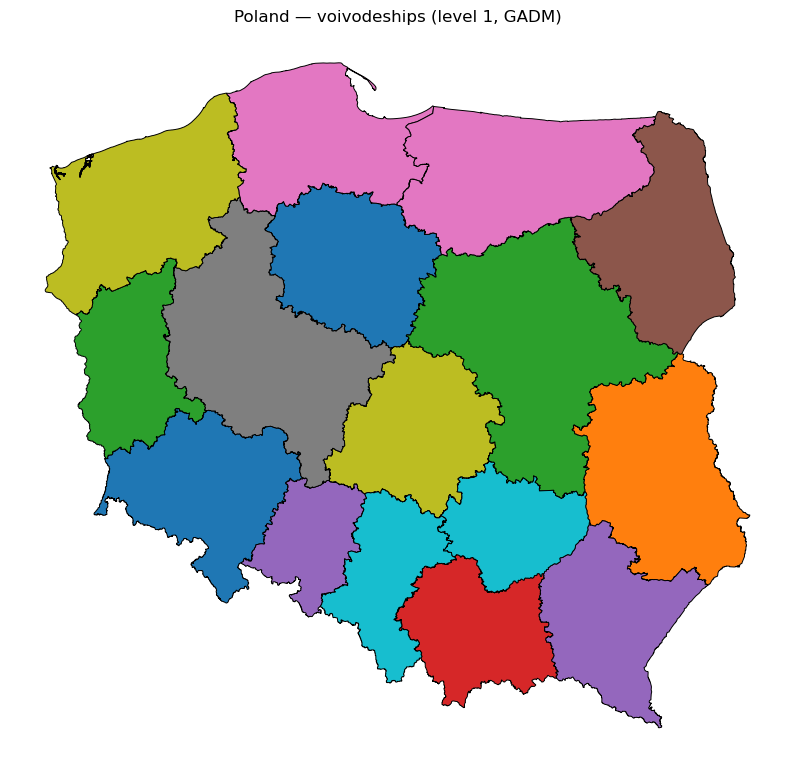

In [3]:
# 1) download GADM (example host: UC Davis geodata mirror)
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_POL_shp.zip"
zip_path = geo_root / "gadm41_POL_shp.zip"
if not os.path.exists(zip_path):
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# 2) unzip (optional) and read level-1 shapefile
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(geo_root / "gadm41_POL_shp")

# shapefile for admin level 1 inside the zip is typically named like: gadm41_POL_1.shp
gdf = gpd.read_file(geo_root / "gadm41_POL_shp/gadm41_POL_1.shp")  # level 1 = voivodeships

# quick inspect
print(gdf.columns)
print(len(gdf), "voivodeships (should be 16)")

# 3) plot
ax = gdf.plot(edgecolor="black", linewidth=0.7, figsize=(10,10), column="NAME_1", legend=False)
ax.set_title("Poland — voivodeships (level 1, GADM)")
ax.axis("off")
plt.show()


Loading SVG from: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/local_repo/LRDWI-Paper/POL_Voivodships_1975.svg
SVG file exists: True

✓ Extracted 49 voivodeships from SVG (target: 49)

Saved to: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/Data/Geospatial/voivodeships_1975.geojson


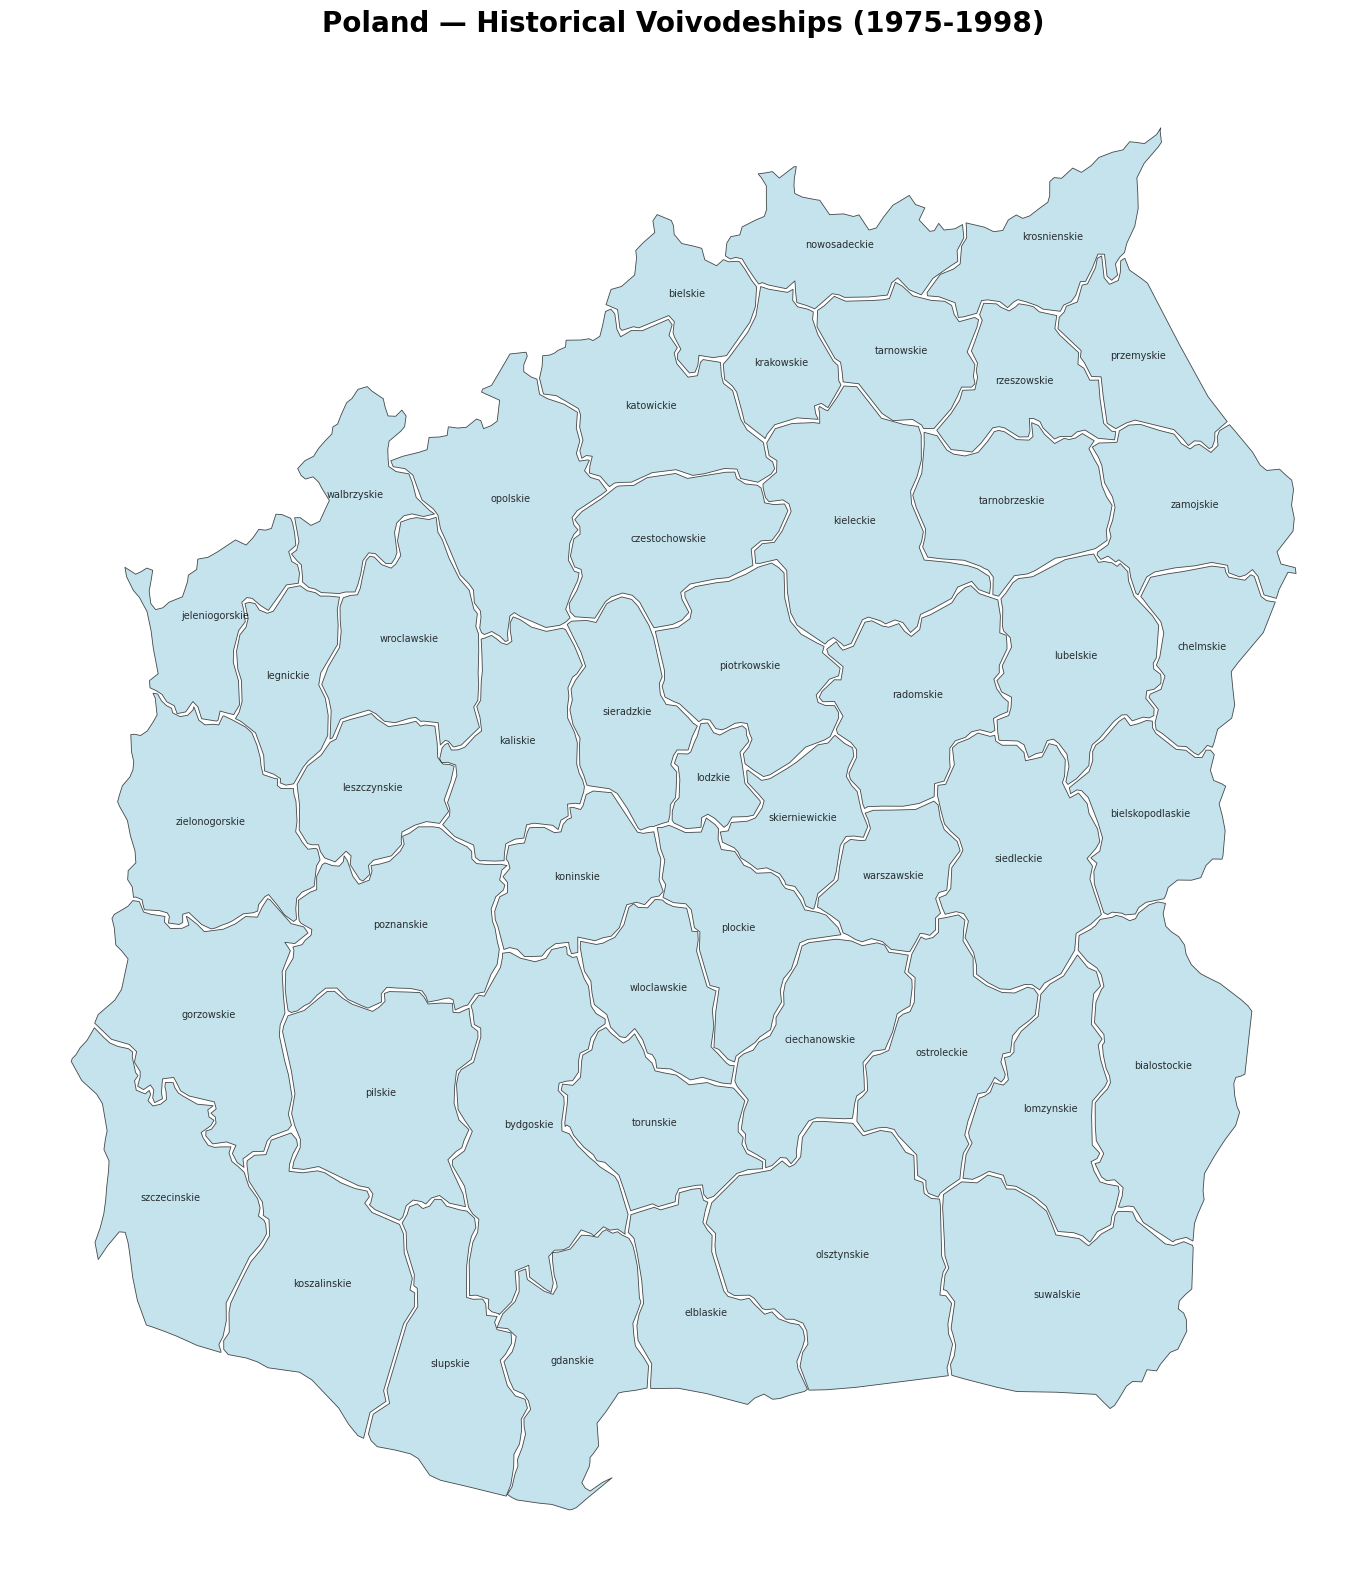


✓ Successfully loaded 49 out of 49 voivodeships
✓ Map orientation: Correct (North up)


In [4]:
# Load the 1975 historical voivodeships from SVG with improved parsing
import xml.etree.ElementTree as ET
import re
from shapely.geometry import Polygon
import numpy as np

# FIXED: SVG is in repo_root, not geo_root
input_svg = repo_root / "POL_Voivodships_1975.svg"
output_geojson = geo_root / "voivodeships_1975.geojson"

print(f"Loading SVG from: {input_svg}")
print(f"SVG file exists: {input_svg.exists()}")

if not input_svg.exists():
    print("ERROR: SVG file not found at expected location!")
else:
    tree = ET.parse(input_svg)
    root = tree.getroot()
    
    # Extract namespace
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    
    # Parse SVG paths
    geometries = []
    names = []
    skipped = []
    
    def parse_path_data(path_data):
        """Parse SVG path data into coordinates - handles M, L, C, H, V, Z commands."""
        coords = []
        tokens = re.findall(r'[MLCZHVmlczhv]|[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', path_data)
        
        i = 0
        current_x, current_y = 0, 0
        start_x, start_y = 0, 0
        
        while i < len(tokens):
            if i >= len(tokens):
                break
                
            cmd = tokens[i]
            
            try:
                if cmd.upper() == 'M':  # Move to
                    if i + 2 < len(tokens):
                        current_x = float(tokens[i+1])
                        current_y = float(tokens[i+2])
                        start_x, start_y = current_x, current_y
                        coords.append((current_x, current_y))
                        i += 3
                    else:
                        i += 1
                        
                elif cmd.upper() == 'L':  # Line to
                    if i + 2 < len(tokens):
                        current_x = float(tokens[i+1])
                        current_y = float(tokens[i+2])
                        coords.append((current_x, current_y))
                        i += 3
                    else:
                        i += 1
                        
                elif cmd.upper() == 'H':  # Horizontal line
                    if i + 1 < len(tokens):
                        current_x = float(tokens[i+1])
                        coords.append((current_x, current_y))
                        i += 2
                    else:
                        i += 1
                        
                elif cmd.upper() == 'V':  # Vertical line
                    if i + 1 < len(tokens):
                        current_y = float(tokens[i+1])
                        coords.append((current_x, current_y))
                        i += 2
                    else:
                        i += 1
                        
                elif cmd.upper() == 'C':  # Cubic Bezier (use end point)
                    if i + 6 < len(tokens):
                        # Skip control points, use end point
                        current_x = float(tokens[i+5])
                        current_y = float(tokens[i+6])
                        coords.append((current_x, current_y))
                        i += 7
                    else:
                        i += 1
                        
                elif cmd.upper() == 'Z':  # Close path
                    if coords and len(coords) > 0:
                        # Optionally close by adding start point if not already closed
                        if coords[-1] != (start_x, start_y):
                            coords.append((start_x, start_y))
                    i += 1
                else:
                    # Try to parse as number (implicit lineto)
                    try:
                        current_x = float(cmd)
                        if i + 1 < len(tokens):
                            current_y = float(tokens[i+1])
                            coords.append((current_x, current_y))
                            i += 2
                        else:
                            i += 1
                    except (ValueError, IndexError):
                        i += 1
            except (ValueError, IndexError) as e:
                # Skip problematic token
                i += 1
                continue
        
        return coords
    
    for path in root.findall('.//svg:path', ns):
        path_id = path.get('id')
        path_data = path.get('d')
        
        if path_id and path_data:
            coords = parse_path_data(path_data)
            
            if len(coords) >= 3:
                try:
                    # Create polygon
                    poly = Polygon(coords)
                    if poly.is_valid and not poly.is_empty:
                        geometries.append(poly)
                        names.append(path_id)
                    else:
                        # Try to fix invalid geometry
                        poly_fixed = poly.buffer(0)
                        if poly_fixed.is_valid and not poly_fixed.is_empty:
                            if poly_fixed.geom_type == 'Polygon':
                                geometries.append(poly_fixed)
                                names.append(path_id)
                            elif poly_fixed.geom_type == 'MultiPolygon':
                                # Take the largest polygon
                                largest = max(poly_fixed.geoms, key=lambda p: p.area)
                                geometries.append(largest)
                                names.append(path_id)
                        else:
                            skipped.append((path_id, f"Invalid after buffer: {len(coords)} coords"))
                except Exception as e:
                    skipped.append((path_id, str(e)))
            else:
                skipped.append((path_id, f"Too few coords: {len(coords)}"))
    
    print(f"\n✓ Extracted {len(geometries)} voivodeships from SVG (target: 49)")
    if skipped:
        print(f"⚠ Skipped {len(skipped)} paths:")
        for name, reason in skipped:
            print(f"  - {name}: {reason}")
    
    # Create GeoDataFrame
    gdf_1975 = gpd.GeoDataFrame({
        'name': names,
        'geometry': geometries
    }, crs='EPSG:4326')
    
    # Save to GeoJSON
    gdf_1975.to_file(output_geojson, driver='GeoJSON')
    print(f"\nSaved to: {output_geojson}")
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    gdf_1975.plot(ax=ax, edgecolor='black', facecolor='lightblue', linewidth=0.6, alpha=0.7)
    ax.set_title('Poland — Historical Voivodeships (1975-1998)', fontsize=20, fontweight='bold', pad=20)
    ax.axis('off')
    
    # Add labels
    for idx, row in gdf_1975.iterrows():
        centroid = row.geometry.centroid
        ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), 
                   horizontalalignment='center', fontsize=7, alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"✓ Successfully loaded {len(gdf_1975)} out of 49 voivodeships")
    print(f"✓ Map orientation: Correct (North up)")
    print(f"{'='*60}")


In [5]:
gdf_1975

,name,geometry
0,szczecinskie,"POLYGON ((333.25018 351.45288, 279.18411 371.1..."
1,bydgoskie,"POLYGON ((1131.1935 418.88147, 1112.3462 423.2..."
2,koninskie,"POLYGON ((1179.9982 1197.4014, 1159.7901 1201...."
3,gdanskie,"POLYGON ((1316.1726 0.39708, 1270.676 11.72053..."
4,koszalinskie,"POLYGON ((758.40081 158.57621, 733.68279 183.1..."
5,slupskie,"POLYGON ((1053.0888 48.87938, 977.30064 63.164..."
6,elblaskie,"POLYGON ((1679.569 248.53823, 1605.4019 259.80..."
7,olsztynskie,"POLYGON ((1950.904 255.80445, 1927.3093 306.68..."
8,bialostockie,"POLYGON ((2913.251 572.39462, 2875.0676 592.38..."
9,suwalskie,"POLYGON ((2746.963 216.48356, 2728.8045 230.70..."


Map bounds: [7.7936132e-01 3.2000000e-07 3.2384729e+03 2.9521807e+03]
Center point: (1619.6261306600002, 1476.0903501599998)


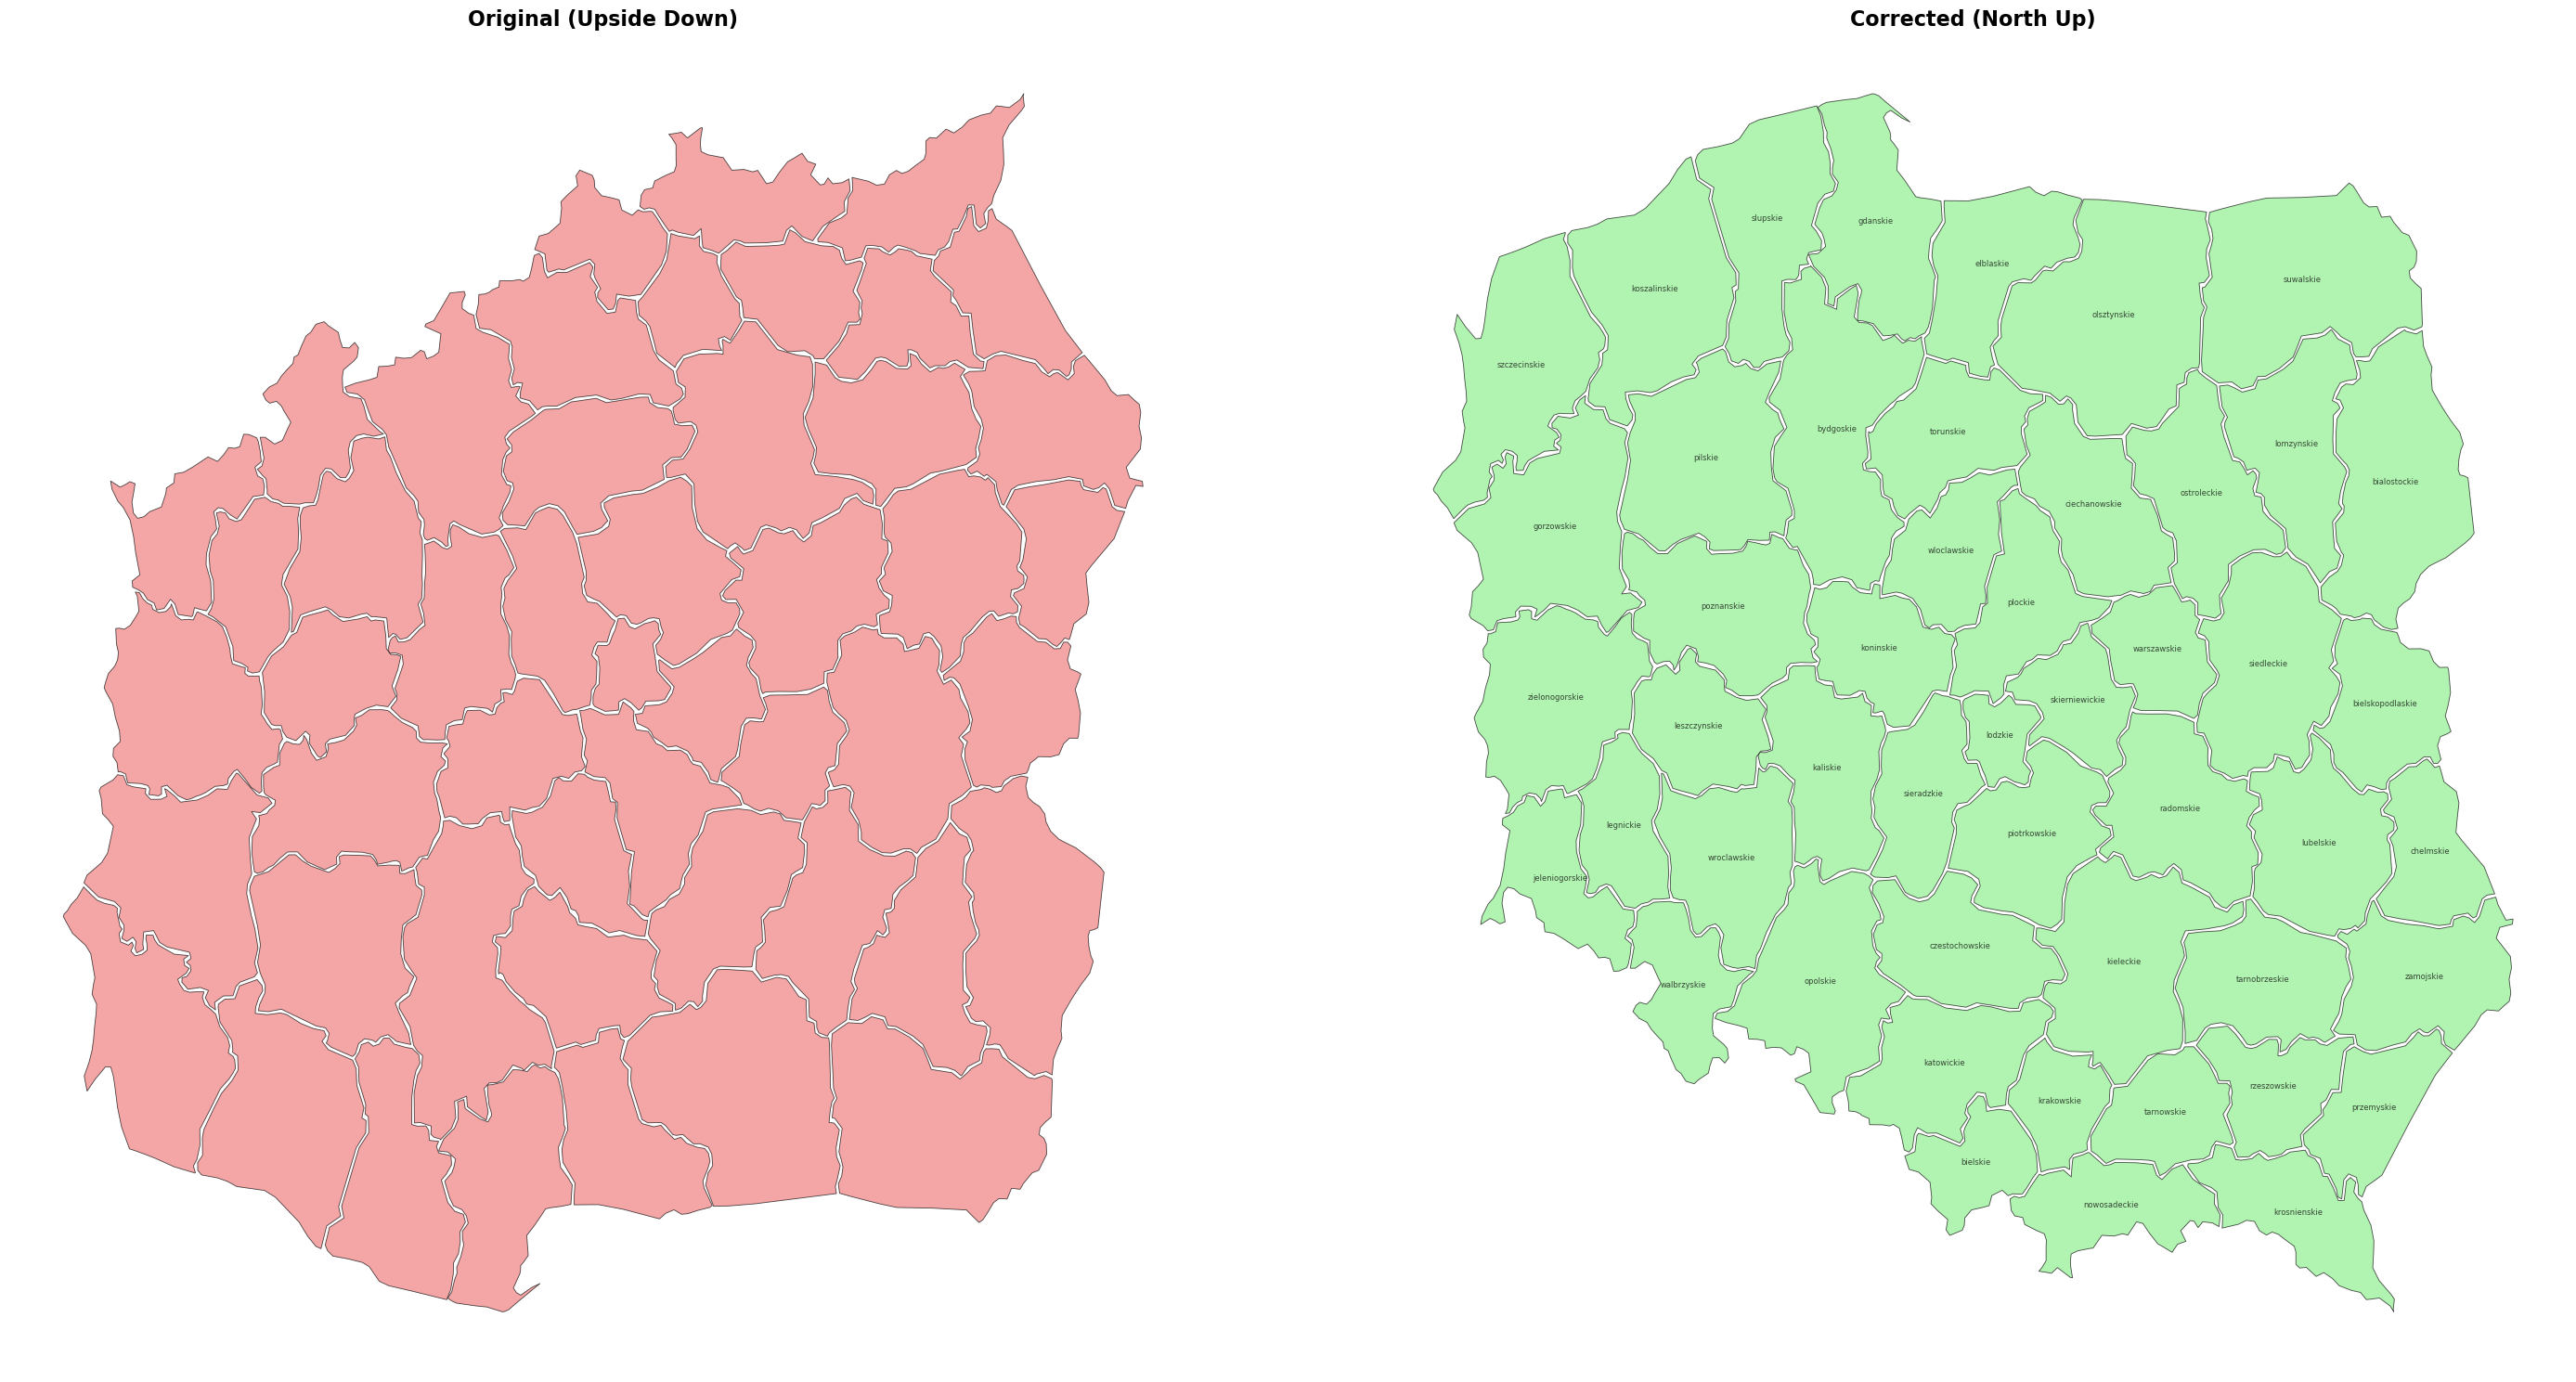


✓ Map successfully rotated to conventional orientation
✓ Saved corrected version to: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/Data/Geospatial/voivodeships_1975_corrected.geojson


In [6]:
# Rotate/flip the map to achieve conventional north-up orientation
from shapely import affinity

# Get the bounds of all geometries to find the center point
bounds = gdf_1975.total_bounds  # [minx, miny, maxx, maxy]
center_x = (bounds[0] + bounds[2]) / 2
center_y = (bounds[1] + bounds[3]) / 2

print(f"Map bounds: {bounds}")
print(f"Center point: ({center_x}, {center_y})")

# Create a copy of the GeoDataFrame
gdf_1975_corrected = gdf_1975.copy()

# Flip the geometries vertically (around the horizontal center line)
# This inverts the Y-axis, converting from SVG coordinates (Y down) to geographic (Y up)
gdf_1975_corrected['geometry'] = gdf_1975_corrected['geometry'].apply(
    lambda geom: affinity.scale(geom, xfact=1, yfact=-1, origin=(center_x, center_y))
)

# Plot the corrected map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
# Make font bigger for both subplots


# Original (left)
gdf_1975.plot(ax=ax1, edgecolor='black', facecolor='lightcoral', linewidth=0.6, alpha=0.7)
ax1.set_title('Original (Upside Down)', fontsize=16, fontweight='bold')
ax1.axis('off')

# Corrected (right)
gdf_1975_corrected.plot(ax=ax2, edgecolor='black', facecolor='lightgreen', linewidth=0.6, alpha=0.7)
ax2.set_title('Corrected (North Up)', fontsize=16, fontweight='bold')
ax2.axis('off')

# Add labels to corrected map
for idx, row in gdf_1975_corrected.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(text=row['name'], xy=(centroid.x, centroid.y), 
                horizontalalignment='center', fontsize=6, alpha=0.7)

plt.tight_layout()
plt.show()

# Save the corrected version
output_geojson_corrected = geo_root / "voivodeships_1975_corrected.geojson"
gdf_1975_corrected.to_file(output_geojson_corrected, driver='GeoJSON')

print(f"\n{'='*60}")
print(f"✓ Map successfully rotated to conventional orientation")
print(f"✓ Saved corrected version to: {output_geojson_corrected}")
print(f"{'='*60}")
